| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant   

# Section 1: Data loading ---------------------------------------------------------------------------------------


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import re
import scipy
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [5]:
loan = pd.read_csv('/content/loan.csv')
loan


,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male
...,...,...,...,...,...,...,...,...,...,...
341,394,394,COLLECTION,800,15,9/11/2016,9/25/2016,32,High School or Below,male
342,395,395,COLLECTION,1000,30,9/11/2016,10/10/2016,25,High School or Below,male
343,397,397,COLLECTION,800,15,9/12/2016,9/26/2016,39,college,male
344,398,398,COLLECTION,1000,30,9/12/2016,11/10/2016,28,college,male


 # Identify variables' data type and convert them if necessary


In [6]:
loan.shape
loan.info()
loan.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.1    346 non-null    int64 
 1   Unnamed: 0      346 non-null    int64 
 2   loan_status     346 non-null    object
 3   Principal       346 non-null    int64 
 4   terms           346 non-null    int64 
 5   effective_date  346 non-null    object
 6   due_date        346 non-null    object
 7   age             346 non-null    int64 
 8   education       346 non-null    object
 9   Gender          346 non-null    object
dtypes: int64(5), object(5)
memory usage: 27.2+ KB


,Unnamed: 0.1,Unnamed: 0,Principal,terms,age
count,346.000000,346.000000,346.000000,346.000000,346.000000
mean,202.167630,202.167630,943.641618,22.653179,30.939306
std,115.459715,115.459715,109.425530,7.991006,6.039418
min,0.000000,0.000000,300.000000,7.000000,18.000000
25%,107.250000,107.250000,900.000000,15.000000,27.000000
50%,204.500000,204.500000,1000.000000,30.000000,30.000000
75%,298.750000,298.750000,1000.000000,30.000000,35.000000
max,399.000000,399.000000,1000.000000,30.000000,51.000000



Input:

    * Principal: Categorical variable (Nominal)
    * Terms: Categorical variable (Ordinal)
    * Effective_date: Time Series
    * Due_date: Time Series
    * Age: Numerical variable (Discrete)
    * Education: Categorical variable (Ordinal)
    * Gender: Categorical variable (Nominal)
  
Output:

    * Loan_status: Categorical variable (Nominal)


# Section 2: Data Preprocessing ---------------------------------------------------------------------------------------


  # Remove unnecessary columns


In [7]:
loan.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], axis = 1, inplace = True)
loan.columns = ['loan_status', 'principal', 'terms', 'effective_date', 'due_date', 'age', 'education', 'gender']


# Identify null and duplicated variables and erase if necessary

In [8]:
loan.isnull().sum()

loan.duplicated().any()
loan.duplicated().sum()
loan[loan.duplicated()]
loan = loan.drop_duplicates().reset_index(drop = True)


Comment:

  * No null values in these variables
  * There are total 40 duplicated rows

  # Convert data type

In [9]:
cols_1 = ['age']
loan[cols_1] = loan[cols_1].apply(pd.to_numeric, errors = 'coerce')

cols_2 = ['loan_status', 'principal', 'terms' ,'effective_date', 'due_date', 'education', 'gender']
loan[cols_2].astype('object')

loan['principal'] = loan['principal'].astype('object')
loan['terms'] = loan['terms'].astype('object')

loan['due_date'] = pd.to_datetime(loan['due_date'])
loan['effective_date'] = pd.to_datetime(loan['effective_date'])

# Apply Feature Engineer to convert the categorical data types into numbers


  # Create new column 'dayofweek_encoder' from 'effective_date'


In [10]:
loan['dayofweek_encoder'] = loan['effective_date'].dt.dayofweek


  # gender (male: 1, female: 0)


In [11]:
loan['gender_encoder'] = loan['gender'].apply(lambda x: 1 if x == 'male' else 0)


  # terms (7: 0, 15: 1, 30: 2)


In [12]:
terms_type_mapping = {7: 0, 15: 1, 30: 2}
label_encoder_s1 = preprocessing.LabelEncoder()
loan['terms_encoder'] = loan['terms'].map(terms_type_mapping)
loan['terms_encoder'] = label_encoder_s1.fit_transform(loan['terms_encoder'])

  # Scaling terms_encoder by Normalization


In [13]:
scaler = MinMaxScaler()
terms_values = loan['terms_encoder'].values.reshape(-1, 1)
loan['scaled_std_terms'] = scaler.fit_transform(terms_values)

  # education ('High School or Below':0, 'college':1,'Bechalor':2, 'Master or Above':3)

In [14]:
education_type_mapping = {'High School or Below':0, 'college':1,'Bechalor':2, 'Master or Above':3}
label_encoder = preprocessing.LabelEncoder()
loan['education_encoder'] = loan['education'].map(education_type_mapping)
loan['education_encoder'] = label_encoder.fit_transform(loan['education_encoder'])

  # principal (300, 500, 800, 900, 1000)

In [15]:
principal_type_mapping = {300:0, 500:1, 800:2, 900:3, 1000:4}
label_encoder = preprocessing.LabelEncoder()
loan['principal_encoder'] = loan['principal'].map(principal_type_mapping)
loan['principal_encoder'] = label_encoder.fit_transform(loan['principal_encoder'])


  # Scaling principal_encoder by Normalization


In [16]:
scaler = MinMaxScaler()
principal_values = loan['principal_encoder'].values.reshape(-1, 1)
loan['scaled_std_principal'] = scaler.fit_transform(principal_values)

  # loan_status (collection: 1, paidoff: 0)

In [17]:
loan['loan_status_encoder'] = loan['loan_status'].apply(lambda x: 1 if x == 'COLLECTION' else 0)


# Reconstructure data

In [18]:
loan_train = loan[['scaled_std_principal', 'scaled_std_terms', 'age', 'education_encoder', 'gender_encoder', 'dayofweek_encoder', 'loan_status_encoder']]


 # Convert data types


In [19]:
loan_train['scaled_std_principal'] = loan['scaled_std_principal'].apply(pd.to_numeric, errors = 'coerce')
loan['scaled_std_terms'] = loan['scaled_std_terms'].apply(pd.to_numeric, errors = 'coerce')

loan_train['gender_encoder'] = loan_train['gender_encoder'].astype('category')
loan_train['education_encoder'] = loan_train['education_encoder'].astype('category')
loan_train['loan_status_encoder'] = loan_train['loan_status_encoder'].astype('category')
loan_train['dayofweek_encoder'] = loan_train['dayofweek_encoder'].astype('category')


<ipython-input-19-321f36346865>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_train['scaled_std_principal'] = loan['scaled_std_principal'].apply(pd.to_numeric, errors = 'coerce')
<ipython-input-19-321f36346865>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_train['gender_encoder'] = loan_train['gender_encoder'].astype('category')
<ipython-input-19-321f36346865>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

# Section 3: Univariate Analysis ---------------------------------------------------------------------------------------
  # Categorical Variables

In [20]:
cat_cols = loan_train.select_dtypes('category').columns
cat_cols = cat_cols.tolist()


* Column: education_encoder
4 unique values

* Column: gender_encoder
2 unique values

* Column: dayofweek_encoder
7 unique values

* Column: loan_status_encoder
2 unique values
Variable:  education_encoder
1    132
0    128
2     44
3      2
Name: education_encoder, dtype: int64


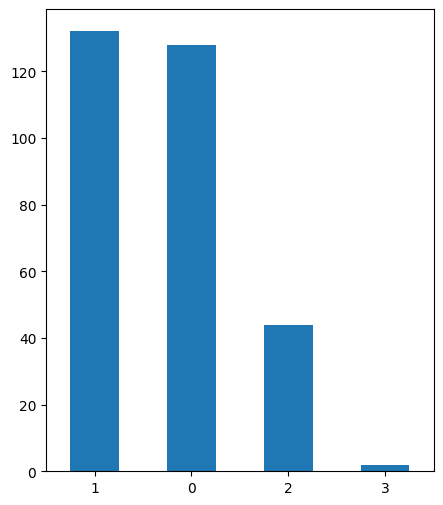


Variable:  gender_encoder
1    255
0     51
Name: gender_encoder, dtype: int64


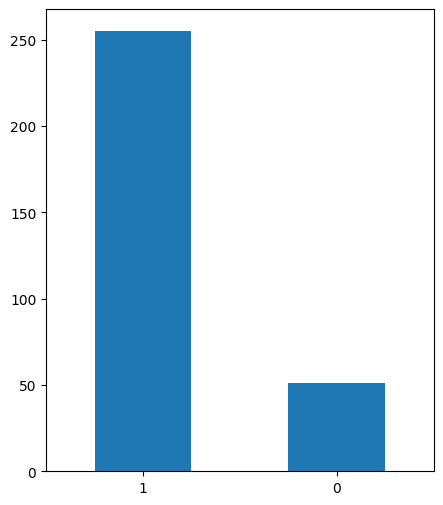


Variable:  dayofweek_encoder
6    139
0     78
2     29
5     29
1     20
4      8
3      3
Name: dayofweek_encoder, dtype: int64


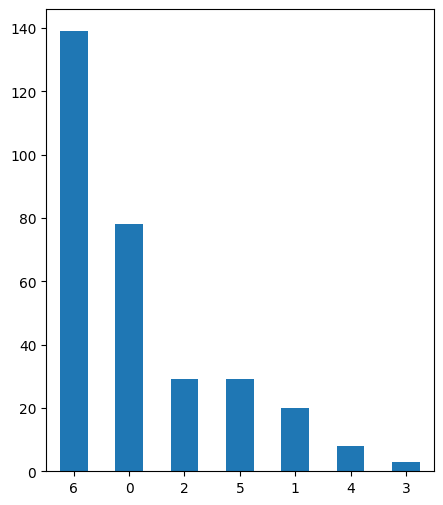


Variable:  loan_status_encoder
0    228
1     78
Name: loan_status_encoder, dtype: int64


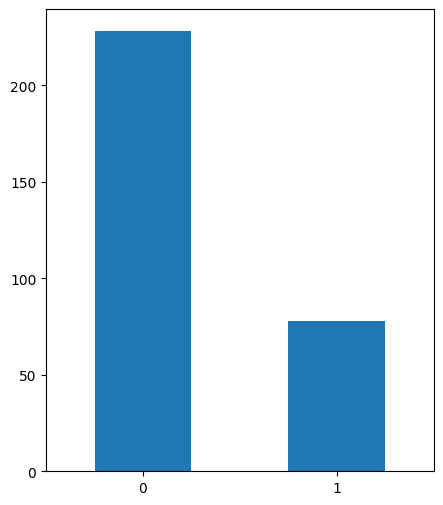

In [21]:
for column in cat_cols:
  print('\n* Column:', column)
  print(len(loan_train[column].unique()), 'unique values')

def univariate_analysis_categorical_variable(df, group_by_col):
    print(df[group_by_col].value_counts())
    df[group_by_col].value_counts().plot.bar(figsize=(5, 6),rot=0)
    plt.show()

for cat in cat_cols:
  print('Variable: ', cat)
  univariate_analysis_categorical_variable(loan_train, cat)
  print()


"""
Comment:

education ('High School or Below':0, 'college':1,'Bechalor':2, 'Master or Above':3)

gender (male: 1, female: 0)

dayofweek (Monday: 0, Sunday: 6)

loan_status (collection: 1, paidoff: 0)

  * education_encoder: Most borrowers are College graduates and High School or below
  * gender_encoder: Male gender dominates the porportion
  * dayofweek_encoder: Borrowers start their loan mostly on Sunday and Monday, Thursday witness the lowest number
  * loan_status_encoder: Significant number of borrowers paid off their debt
"""

 # Numerical Variables

In [22]:
num_cols = loan_train.select_dtypes('number').columns
num_cols = num_cols.tolist()


In [23]:
for column in num_cols:
  print('\n* Column:', column)
  print(len(loan_train[column].unique()), 'unique values')


* Column: scaled_std_principal
5 unique values

* Column: scaled_std_terms
3 unique values

* Column: age
32 unique values


In [24]:
def univariate_analysis_continuous_variable(df, feature):
    print("Describe:")
    print(feature.describe(include='all'))
    print("Mode:", feature.mode())
    print("Range:", feature.values.ptp())
    print("IQR:", scipy.stats.iqr(feature))
    print("Var:", feature.var())
    print("Std:", feature.std())
    print("Skew:", feature.skew())
    print("Kurtosis:", feature.kurtosis())

In [25]:
def check_outlier(df, feature):
    plt.boxplot(feature)
    plt.show()
    Q1 = np.percentile(feature, 25)
    Q3 = np.percentile(feature, 75)
    n_O_upper = df[feature > (Q3 + 1.5*scipy.stats.iqr(feature))].shape[0]
    print("Number of upper outliers:", n_O_upper)
    n_O_lower = df[feature < (Q1 - 1.5*scipy.stats.iqr(feature))].shape[0]
    print("Number of lower outliers:", n_O_lower)
    # Percentage of ouliers
    outliers_per = (n_O_lower + n_O_upper)/df.shape[0]
    print("Percentage of ouliers:", outliers_per)
    return Q1, Q3, n_O_upper, n_O_lower, outliers_per

In [26]:
def univariate_visualization_analysis_continuous_variable_new(feature):
    # Histogram
    feature.plot.kde()
    plt.show()
    feature.plot.hist()
    plt.show()

Variable:  scaled_std_principal
Describe:
count    306.000000
mean       0.861111
std        0.236762
min        0.000000
25%        0.500000
50%        1.000000
75%        1.000000
max        1.000000
Name: scaled_std_principal, dtype: float64
Mode: 0    1.0
Name: scaled_std_principal, dtype: float64
Range: 1.0
IQR: 0.5
Var: 0.05605646630236794
Std: 0.23676246810330379
Skew: -1.3194819408444194
Kurtosis: 0.46852484175928844


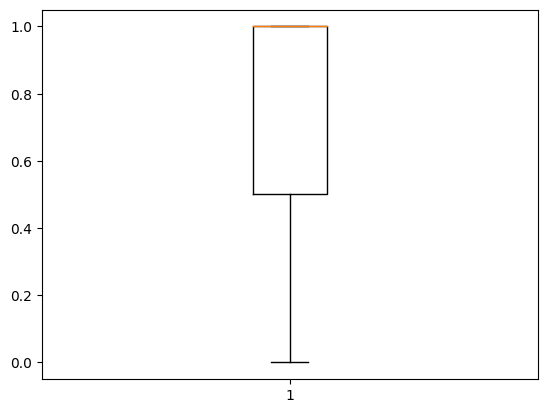

Number of upper outliers: 0
Number of lower outliers: 0
Percentage of ouliers: 0.0


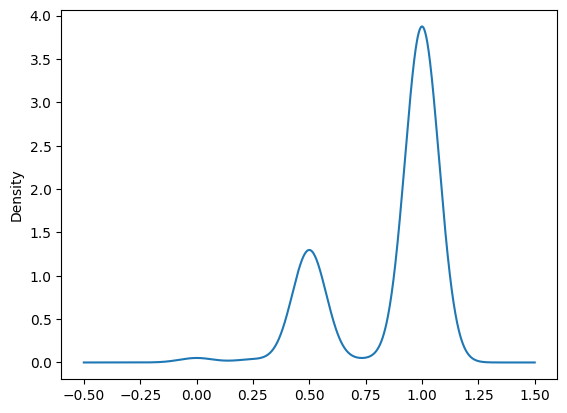

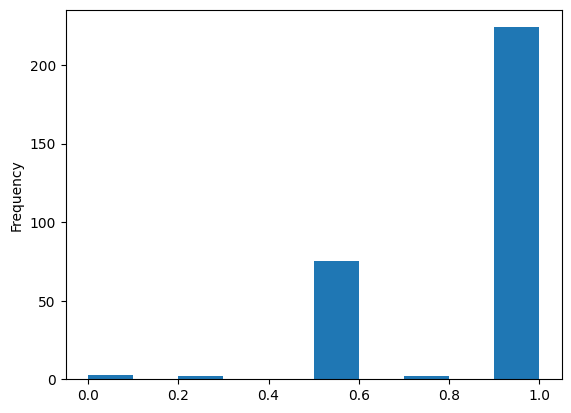


Variable:  scaled_std_terms
Describe:
count    306.000000
mean       0.728758
std        0.291896
min        0.000000
25%        0.500000
50%        1.000000
75%        1.000000
max        1.000000
Name: scaled_std_terms, dtype: float64
Mode: 0    1.0
Name: scaled_std_terms, dtype: float64
Range: 1.0
IQR: 0.5
Var: 0.0852030429658202
Std: 0.2918956028545483
Skew: -0.5304332213064926
Kurtosis: -0.6528685021260165


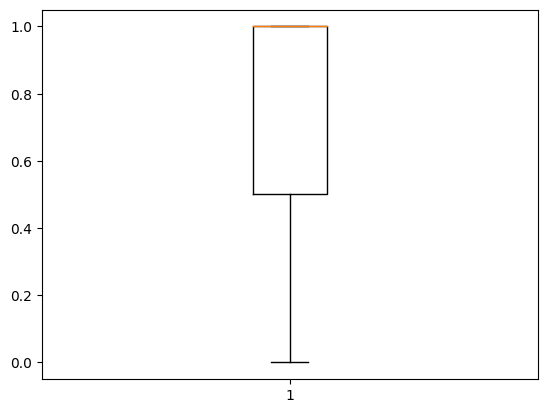

Number of upper outliers: 0
Number of lower outliers: 0
Percentage of ouliers: 0.0


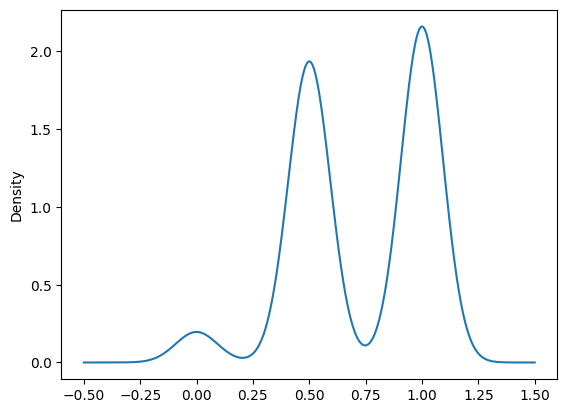

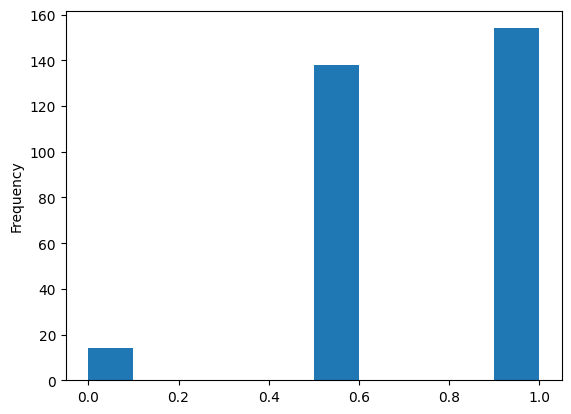


Variable:  age
Describe:
count    306.000000
mean      31.179739
std        6.192305
min       18.000000
25%       27.000000
50%       30.000000
75%       35.000000
max       51.000000
Name: age, dtype: float64
Mode: 0    26
Name: age, dtype: int64
Range: 33
IQR: 8.0
Var: 38.344637308475306
Std: 6.192304684725656
Skew: 0.6438827634685638
Kurtosis: 0.3395282542972726


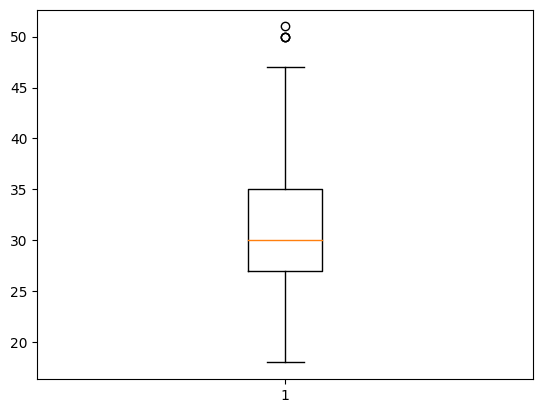

Number of upper outliers: 4
Number of lower outliers: 0
Percentage of ouliers: 0.013071895424836602


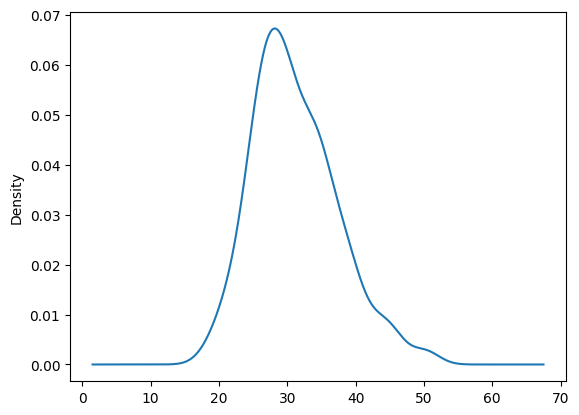

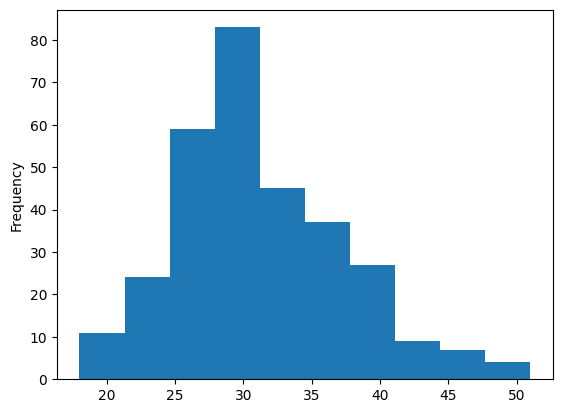

In [27]:
for con in num_cols:
  print('Variable: ', con)
  univariate_analysis_continuous_variable(loan_train, loan_train[con])
  check_outlier(loan_train, loan_train[con])
  univariate_visualization_analysis_continuous_variable_new(loan_train[con])
  print()

"""
Comment:

  * scaled_std_principal: no outliers, most common value is 0.58, positive Kurtosis with 2 tops and left-sided skewness
  * scaled_std_terms: no outliers, most common value is 0.93, negative Kurtosis with 2 tops and left-sided skewness
  * age: few outliers (4), most common value is 26, positive Kurtosis and right-sided skewness (a bit like Normal Distribution)
"""

# Section 4: Bivariate Analysis: Input - Output ---------------------------------------------------------------------------------------
  # Numerical - Categorical


In [28]:
output = 'loan_status_encoder'
cat_cols.remove('loan_status_encoder')


# ANOVA

In [29]:
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [30]:
def variables_cont_cat(df, col1, col2):
    df_sub = df[[col1, col2]]
    plt.figure(figsize=(5,6))
    sns.boxplot(x=col1, y=col2, data=df_sub, palette="Set3")
    plt.show()
    chuoi = str(col2)+' ~ '+str(col1)
    model = ols(chuoi, data=df_sub).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print('ANOVA table: ', anova_table)


2 variables: loan_status_encoder and scaled_std_principal


<ipython-input-30-d09864e4550c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col1, y=col2, data=df_sub, palette="Set3")


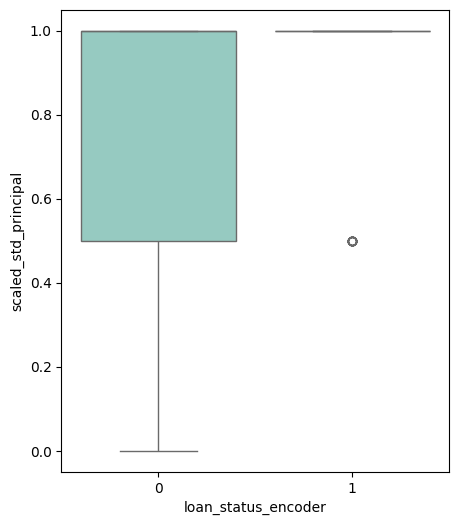

ANOVA table:                          sum_sq     df         F   PR(>F)
loan_status_encoder   0.093680    1.0  1.674865  0.19659
Residual             17.003543  304.0       NaN      NaN

2 variables: loan_status_encoder and scaled_std_terms


<ipython-input-30-d09864e4550c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col1, y=col2, data=df_sub, palette="Set3")


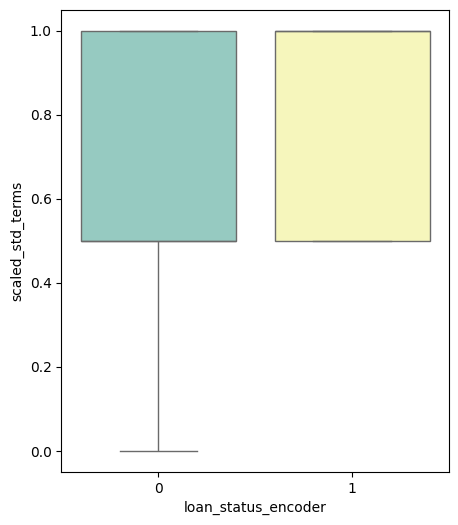

ANOVA table:                          sum_sq     df        F    PR(>F)
loan_status_encoder   0.457576    1.0  5.44875  0.020234
Residual             25.529352  304.0      NaN       NaN

2 variables: loan_status_encoder and age


<ipython-input-30-d09864e4550c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col1, y=col2, data=df_sub, palette="Set3")


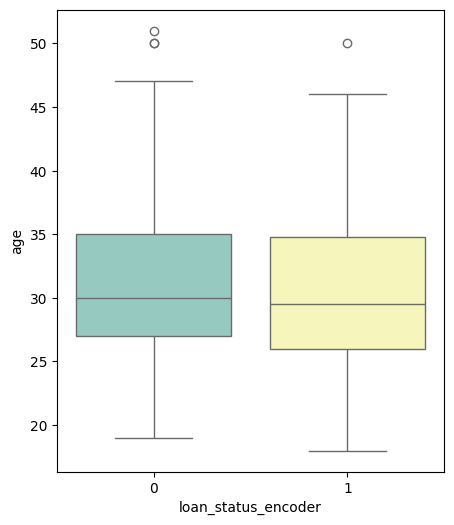

ANOVA table:                             sum_sq     df        F    PR(>F)
loan_status_encoder      9.117753    1.0  0.23719  0.626594
Residual             11685.996626  304.0      NaN       NaN



In [31]:
col1 = 'loan_status_encoder'
for i in range(0, len(num_cols)):
    col2 = num_cols[i]
    print('2 variables:', col1, 'and', col2)
    variables_cont_cat(loan_train, col1, col2)
    print()

"""
Comment:

  * loan_status_encoder and scaled_std_principal: suggests that there's an influence because the P-value (0.19) < 0.05
  * loan_status_encoder and scaled_std_terms: suggests that there's an influence because the P-value (0.02) < 0.05
  * loan_status_encoder and age: suggests that there's no influence because the P-value (0.6) > 0.05

There's a weak relationship between input(age) and output(loan_status)
    => We may consider to drop the 'age' feature, compared to principal feature, it has a bit stronger link so we may keep it
"""


'''
Check the Numerical variables in 2 group (Collection: 1, Paidoff: 0) of loan_status_encoder

*  **H0:** There is no mean difference in turn of Numerical variables between Collection: 1, Paidoff: 0
*  **H1:** There is mean difference in turn of Numerical variables between Collection: 1, Paidoff: 0
'''

In [32]:
from statsmodels.stats.weightstats import ztest


In [34]:
def z_test_loop(data, group_column, value_columns, alpha):

    results = {}
    for column in value_columns:
        group1_data = data[data[group_column] == 0][column]
        group2_data = data[data[group_column] == 1][column]
        z_score, p_value = ztest(group1_data, group2_data, value=group1_data.mean())
        if p_value > alpha:
            result = "Accept the null hypothesis that the means are equal."
        else:
            result = "Reject the null hypothesis that the means are equal."
        results[column] = result
    return results

In [35]:
group_column = 'loan_status_encoder'
alpha = 0.05


In [36]:
for i in range(len(num_cols)):
    value_columns = [num_cols[i]]
    results = z_test_loop(loan_train, group_column, value_columns, alpha)
    for column, result in results.items():
        print("Column: {}".format(column))
        print(result)
        print()


Column: scaled_std_principal
Reject the null hypothesis that the means are equal.

Column: scaled_std_terms
Reject the null hypothesis that the means are equal.

Column: age
Reject the null hypothesis that the means are equal.



'''
Comment:

Since p-value of 'age' is less than 0.05, we have enough evidence to reject hypothesis H0.

However, p-values of 'scaled_std_principal' and 'scaled_std_terms' is higher than 0.05, we don't have enough evidence to reject hypothesis H0
'''

  # Categorical - Categorical


In [37]:
col2 = 'loan_status_encoder'
lst = []

2 variables: education_encoder and loan_status_encoder
loan_status_encoder   0   1
education_encoder          
0                    95  33
1                    99  33
2                    33  11
3                     1   1


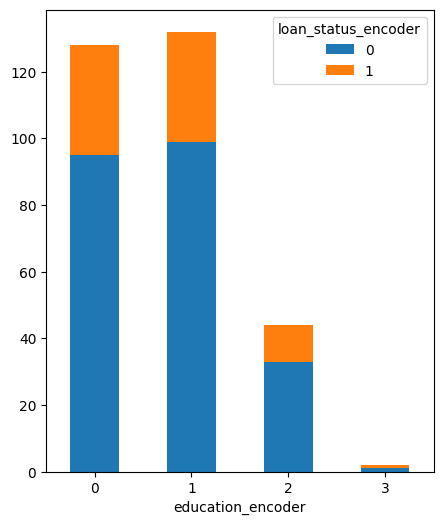

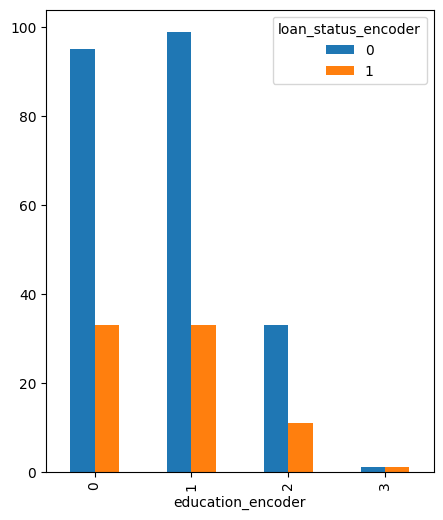

dof=3
p= 0.8824373045578655
probability=0.950, critical=7.815, stat=0.661
significance=0.050, p=0.882
Independent (fail to reject H0)

2 variables: gender_encoder and loan_status_encoder
loan_status_encoder    0   1
gender_encoder              
0                     45   6
1                    183  72


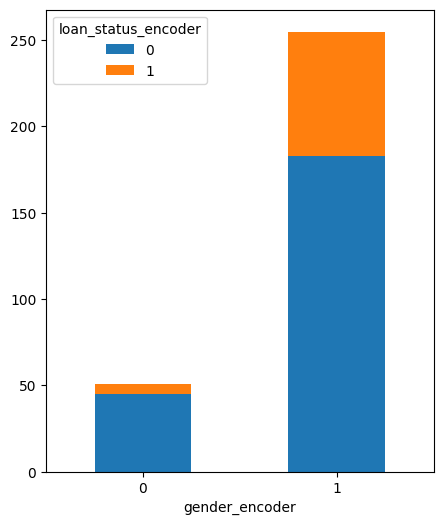

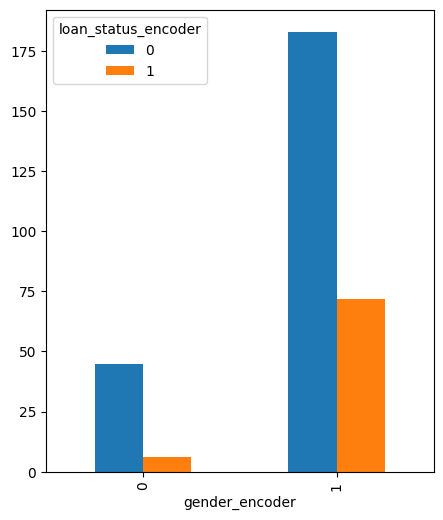

dof=1
p= 0.022146857526296707
probability=0.950, critical=3.841, stat=5.234
significance=0.050, p=0.022
Dependent (reject H0)

2 variables: dayofweek_encoder and loan_status_encoder
loan_status_encoder   0   1
dayofweek_encoder          
0                    75   3
1                    20   0
2                    29   0
3                     3   0
4                     4   4
5                    15  14
6                    82  57


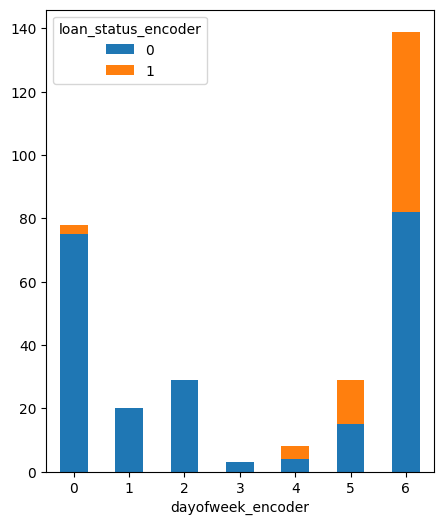

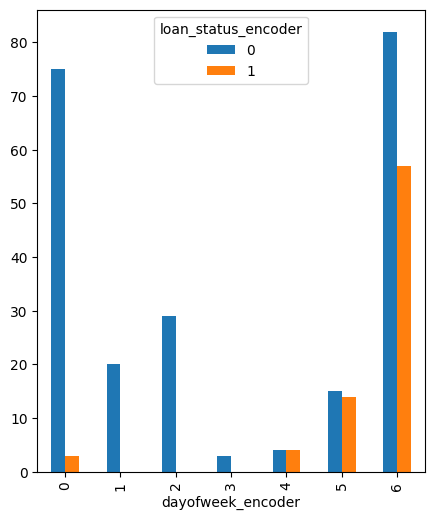

dof=6
p= 4.100466619118799e-12
probability=0.950, critical=12.592, stat=65.108
significance=0.050, p=0.000
Dependent (reject H0)



In [42]:
def categorical_categorical(feature1, feature2):
    # Contingency table
    table_FB = pd.crosstab(feature1, feature2)
    print(table_FB)
    table_FB.plot(kind='bar', stacked=True, figsize=(5, 6),rot=0)
    plt.show()
    table_FB.plot.bar(figsize=(5, 6))
    plt.show()

    # Chi-Square Test
    stat, p, dof, expected = chi2_contingency(table_FB)
    print('dof=%d' % dof)
    print('p=', p)
    # interpret test-statistic
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    # interpret p-value
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print('Dependent (reject H0)')
        x1 = feature1.name
        x2 = feature2.name
        chuoi = x1 + ' and ' + x2
        return chuoi
    else:
        print('Independent (fail to reject H0)')

for i in range(0, len(cat_cols)):
    col1 = cat_cols[i]
    print('2 variables:', col1, 'and', col2)
    chuoi = categorical_categorical(loan_train[col1], loan_train[col2])
    lst.append(chuoi)
    print()

"""
Comment:

  * education_encoder and loan_status_encoder: p-value (0.88) > alpha (0.05) => fail to reject the null hypothesis => 2 independent variables
  * gender_encoder and loan_status_encoder: p-value (0.02) < alpha (0.05) => reject the null hypothesis => 2 dependent variables
  * dayofweek_encoder and loan_status_encoder: p-value (4.1e-12) < alpha (0.05) => reject the null hypothesis => 2 dependent variables
"""

# Section 4: Bivariate Analysis: Input - Input ---------------------------------------------------------------------------------------
  # Numerical - Numerical

Correlation between 2 variables: scaled_std_principal and scaled_std_terms
                      scaled_std_principal  scaled_std_terms
scaled_std_principal               1.00000           0.50868
scaled_std_terms                   0.50868           1.00000
Pearson Correlation between 2 variables: scaled_std_principal and scaled_std_terms
PearsonRResult(statistic=0.5086798718442441, pvalue=1.5272053826749724e-21)
Spearman Correlation between 2 variables: scaled_std_principal and scaled_std_terms
SignificanceResult(statistic=0.5207621477707567, pvalue=1.1398776654478247e-22)


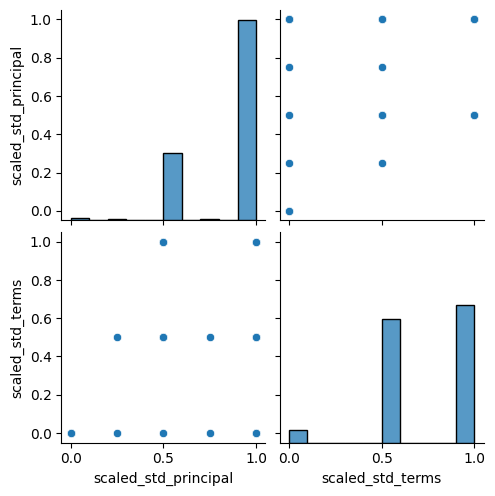


Correlation between 2 variables: scaled_std_principal and age
                      scaled_std_principal       age
scaled_std_principal              1.000000 -0.088583
age                              -0.088583  1.000000
Pearson Correlation between 2 variables: scaled_std_principal and age
PearsonRResult(statistic=-0.08858333154324405, pvalue=0.12203822775328849)
Spearman Correlation between 2 variables: scaled_std_principal and age
SignificanceResult(statistic=-0.08898839242841837, pvalue=0.12033394153508188)


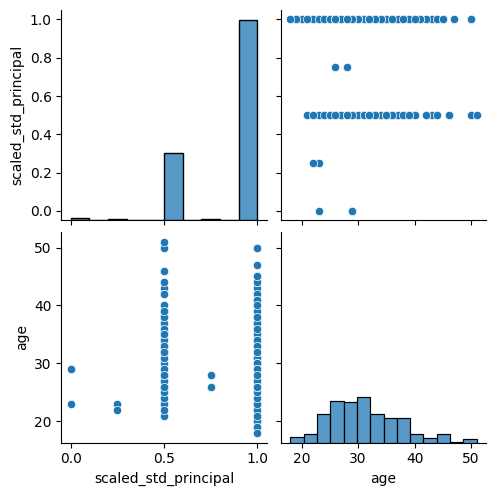


Correlation between 2 variables: scaled_std_terms and age
                  scaled_std_terms       age
scaled_std_terms          1.000000 -0.020101
age                      -0.020101  1.000000
Pearson Correlation between 2 variables: scaled_std_terms and age
PearsonRResult(statistic=-0.020101416121581242, pvalue=0.7261680046975888)
Spearman Correlation between 2 variables: scaled_std_terms and age
SignificanceResult(statistic=-0.013026928318857314, pvalue=0.8204585948533356)


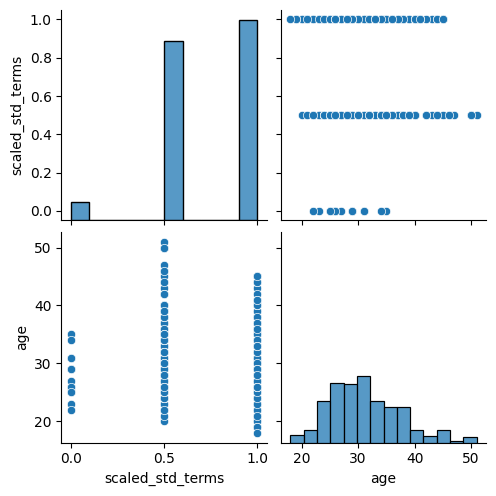

In [43]:
for i in range(0, len(num_cols)):
    col1 = num_cols[i]
    for j in range(i+1, len(num_cols)):
        col2 = num_cols[j]
        print('Correlation between 2 variables:', col1, 'and', col2)
        print(loan_train[[col1, col2]].corr())
        print('Pearson Correlation between 2 variables:', col1, 'and', col2)
        print(stats.pearsonr(loan_train[col1], loan_train[col2]))
        print('Spearman Correlation between 2 variables:', col1, 'and', col2)
        print(stats.spearmanr(loan_train[col1], loan_train[col2]))
        sns.pairplot(loan_train[[col1, col2]])
        plt.show()
        print()


"""
Comment:

  * scaled_std_principal and scaled_std_terms: moderate positive linear relationship and moderate positive monotonic relationship
  * scaled_std_principal and age: strongly negative linear relationship and strongly negative monotonic relationship
  * scaled_std_terms and age: almost no linear relationship and very weak monotonic relationship

There's a weak/not too significant relationship between age column and others
"""

# Section 4: Bivariate Analysis: Input - Input
  # Categorical - Categorical

2 variables: education_encoder and gender_encoder
gender_encoder      0    1
education_encoder         
0                  19  109
1                  22  110
2                  10   34
3                   0    2


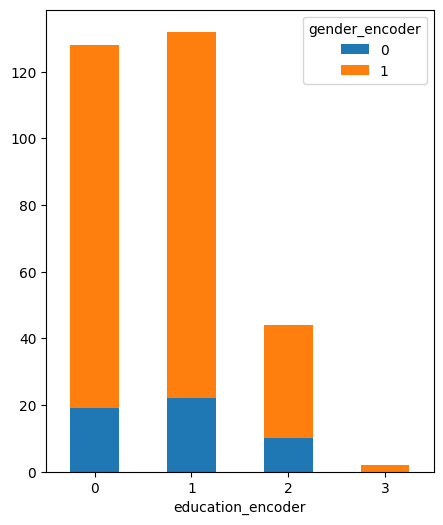

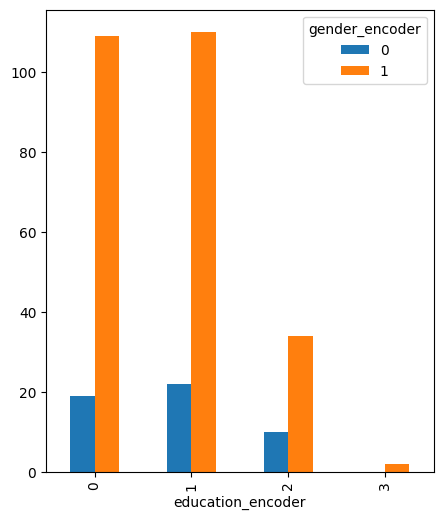

dof=3
p= 0.59984621511017
probability=0.950, critical=7.815, stat=1.870
significance=0.050, p=0.600
Independent (fail to reject H0)

2 variables: education_encoder and dayofweek_encoder
dayofweek_encoder   0   1   2  3  4   5   6
education_encoder                          
0                  40   7  11  1  1  12  56
1                  31  10  12  1  6  13  59
2                   7   3   6  1  1   4  22
3                   0   0   0  0  0   0   2


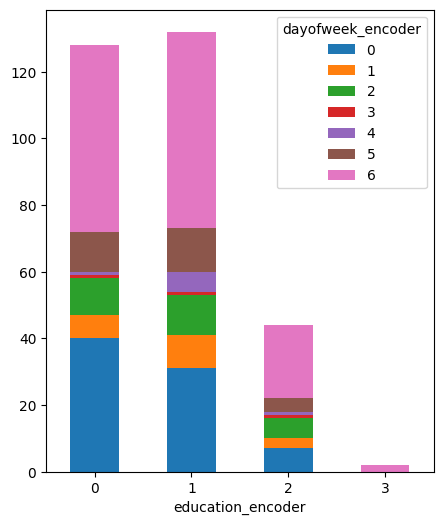

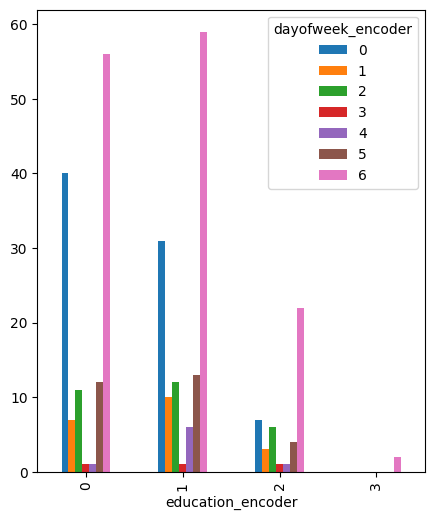

dof=18
p= 0.8483560421777905
probability=0.950, critical=28.869, stat=11.978
significance=0.050, p=0.848
Independent (fail to reject H0)

2 variables: gender_encoder and dayofweek_encoder
dayofweek_encoder   0   1   2  3  4   5    6
gender_encoder                              
0                  16   6   3  1  1   1   23
1                  62  14  26  2  7  28  116


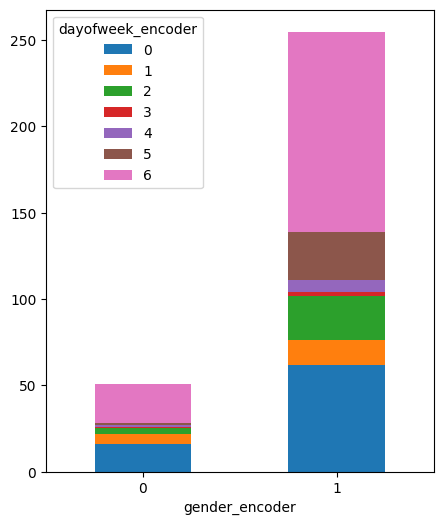

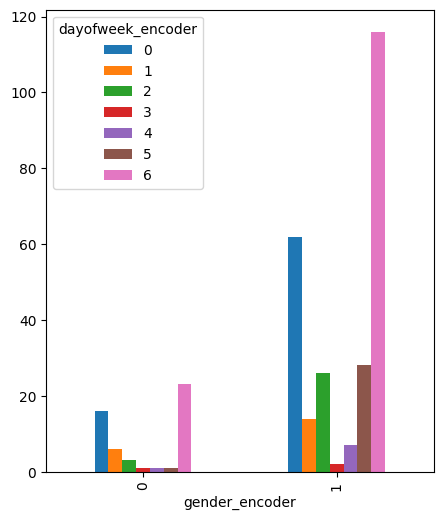

dof=6
p= 0.19893005918280254
probability=0.950, critical=12.592, stat=8.575
significance=0.050, p=0.199
Independent (fail to reject H0)



In [44]:
lst = []
for i in range (0, len(cat_cols)):
  col1 = cat_cols[i]
  for j in range (i+1, len(cat_cols)):
    col2 = cat_cols[j]
    print('2 variables:', col1, 'and', col2)
    chuoi = categorical_categorical(loan_train[col1], loan_train[col2])
    lst.append(chuoi)
    print()

"""
Comment:

  * education_encoder and gender_encoder: p-value (0.59) > alpha (0.05) => fail to reject the null hypothesis => 2 independent variables
  * education_encoder and dayofweek_encoder: p-value (0.84) > alpha (0.05) => fail to reject the null hypothesis => 2 independent variables
  * gender_encoder and dayofweek_encoder: p-value (0.19) > alpha (0.05) => fail to reject the null hypothesis => 2 independent variables
"""

# Section 4: Bivariate Analysis: Input - Input
  # Numerical - Categorical

2 variables: education_encoder and scaled_std_principal


<ipython-input-30-d09864e4550c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col1, y=col2, data=df_sub, palette="Set3")


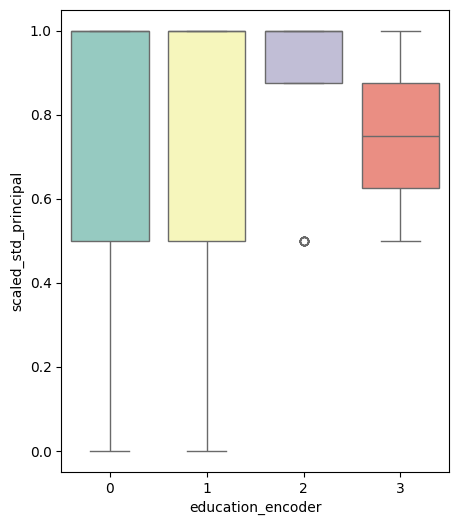

ANOVA table:                        sum_sq     df         F    PR(>F)
education_encoder   0.034500    3.0  0.203545  0.893904
Residual           17.062722  302.0       NaN       NaN

2 variables: education_encoder and scaled_std_terms


<ipython-input-30-d09864e4550c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col1, y=col2, data=df_sub, palette="Set3")


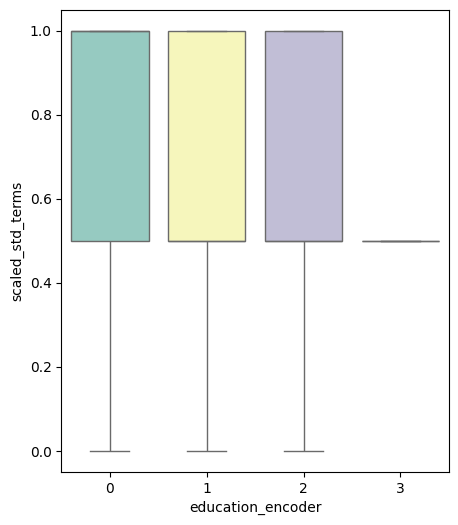

ANOVA table:                        sum_sq     df         F   PR(>F)
education_encoder   0.199049    3.0  0.777017  0.50757
Residual           25.787879  302.0       NaN      NaN

2 variables: education_encoder and age


<ipython-input-30-d09864e4550c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col1, y=col2, data=df_sub, palette="Set3")


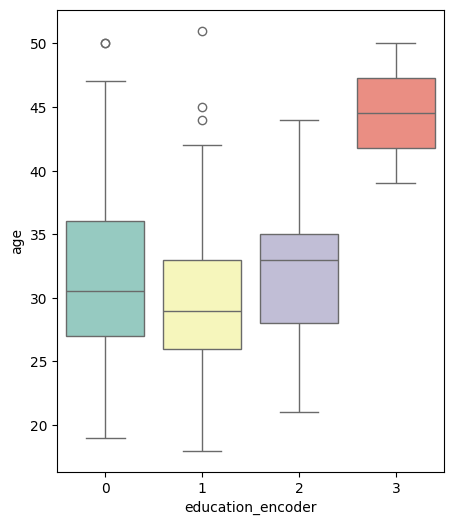

ANOVA table:                           sum_sq     df         F    PR(>F)
education_encoder    584.033176    3.0  5.291355  0.001438
Residual           11111.081203  302.0       NaN       NaN

2 variables: gender_encoder and scaled_std_principal


<ipython-input-30-d09864e4550c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col1, y=col2, data=df_sub, palette="Set3")


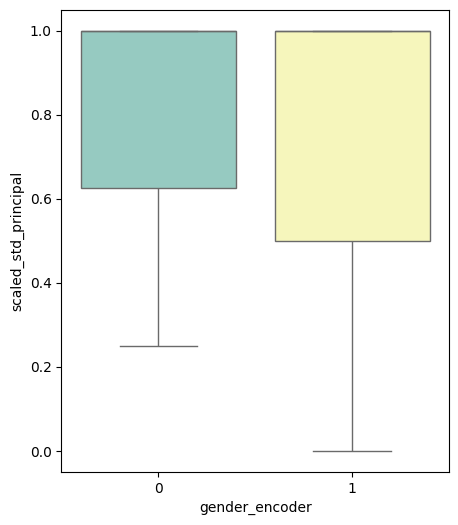

ANOVA table:                     sum_sq     df         F    PR(>F)
gender_encoder   0.000163    1.0  0.002905  0.957049
Residual        17.097059  304.0       NaN       NaN

2 variables: gender_encoder and scaled_std_terms


<ipython-input-30-d09864e4550c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col1, y=col2, data=df_sub, palette="Set3")


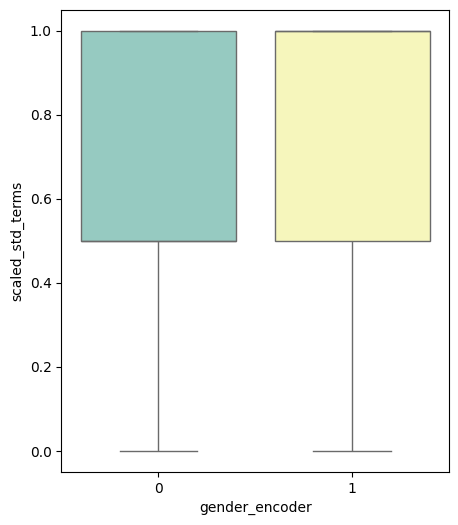

ANOVA table:                     sum_sq     df         F    PR(>F)
gender_encoder   0.010458    1.0  0.122383  0.726706
Residual        25.976471  304.0       NaN       NaN

2 variables: gender_encoder and age


<ipython-input-30-d09864e4550c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col1, y=col2, data=df_sub, palette="Set3")


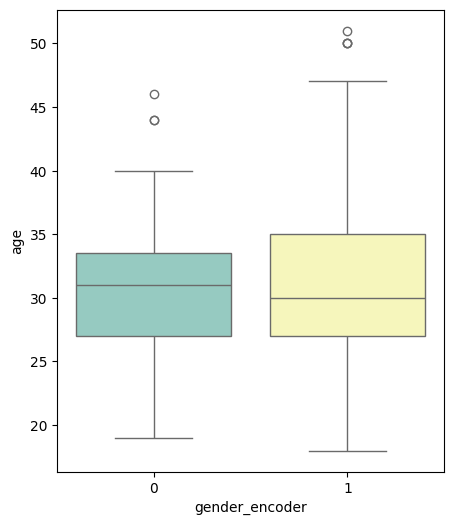

ANOVA table:                        sum_sq     df         F    PR(>F)
gender_encoder      8.643791    1.0  0.224851  0.635709
Residual        11686.470588  304.0       NaN       NaN

2 variables: dayofweek_encoder and scaled_std_principal


<ipython-input-30-d09864e4550c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col1, y=col2, data=df_sub, palette="Set3")


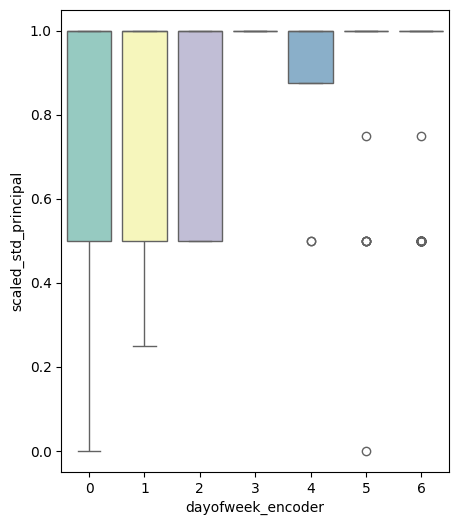

ANOVA table:                        sum_sq     df         F    PR(>F)
dayofweek_encoder   0.312517    6.0  0.927853  0.475112
Residual           16.784706  299.0       NaN       NaN

2 variables: dayofweek_encoder and scaled_std_terms


<ipython-input-30-d09864e4550c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col1, y=col2, data=df_sub, palette="Set3")


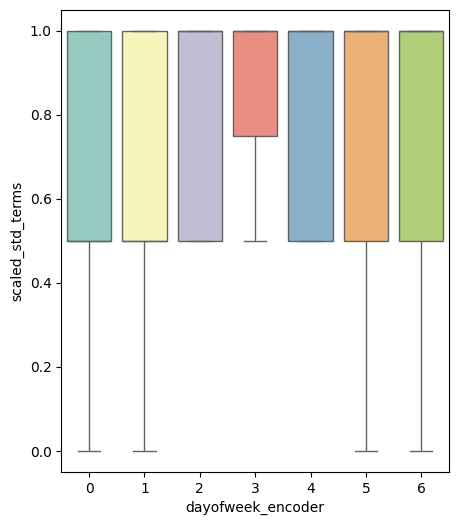

ANOVA table:                        sum_sq     df         F    PR(>F)
dayofweek_encoder   1.146827    6.0  2.300724  0.034633
Residual           24.840101  299.0       NaN       NaN

2 variables: dayofweek_encoder and age


<ipython-input-30-d09864e4550c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col1, y=col2, data=df_sub, palette="Set3")


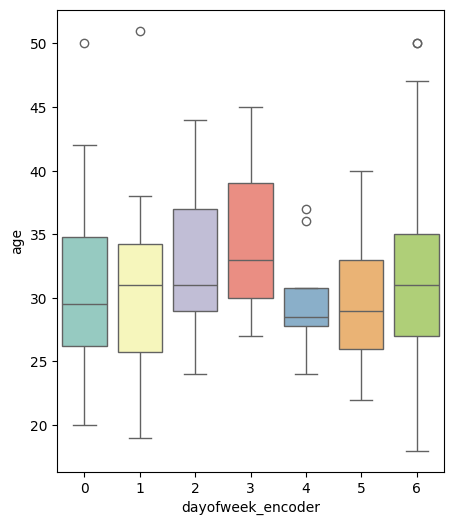

ANOVA table:                           sum_sq     df         F    PR(>F)
dayofweek_encoder    270.123774    6.0  1.178221  0.317752
Residual           11424.990605  299.0       NaN       NaN



In [45]:
for i in range(0, len(cat_cols)):
    col1 = cat_cols[i]
    for j in range(0, len(num_cols)):
        col2 = num_cols[j]
        print('2 variables:', col1, 'and', col2)
        variables_cont_cat(loan_train, col1, col2)
        print()


"""
Comment:

  * education_encoder and scaled_std_principal: suggests that there's no influence because the P-value (0.89) > 0.05
  * education_encoder and scaled_std_terms: suggests that there's no influence because the P-value (0.5) > 0.05
  * education_encoder and age: suggests that there's an influence because the P-value (0.001) < 0.05
---
  * gender_encoder and scaled_std_principal: suggests that there's no influence because the P-value (0.9) > 0.05
  * gender_encoder and scaled_std_terms: suggests that there's no influence because the P-value (0.72) > 0.05
  * gender_encoder and age: suggests that there's no influence because the P-value (0.63) > 0.05
---
  * dayofweek_encoder and scaled_std_principal: suggests that there's no influence because the P-value (0.47) > 0.05
  * dayofweek_encoder and scaled_std_terms: suggests that there's an influence because the P-value (0.03) < 0.05
  * dayofweek_encoder and age: suggests that there's no influence because the P-value (0.31) > 0.05
"""
'''
Recommend removing the attribute age.

Because:

  * ANOVA: The age column does not show a significant influence on the output variable (loan_status_encoder), as the p-value is higher than the significance level of 0.05.
      Therefore, removing the age column would not have a major impact on the analysis based on the ANOVA results.
  * Chi-squared: The age column is not directly involved in the chi-squared analysis, as it focuses on the relationship between categorical variables.
      Removing the age column would not affect the chi-squared analysis or the determination of independence between variables.
  * Pearson and Spearman Coefficients: Removing the age column would result in the loss of the relationship between scaled_std_terms and age.
      However, based on the analysis results, the relationship between scaled_std_terms and age is considered to have almost
      no linear relationship and a very weak monotonic relationship.
      Therefore, removing the age column would not significantly impact the overall analysis based on the correlation coefficients.
'''

# Section 5: Data Prediction ---------------------------------------------------------------------------------------



In [46]:
X = loan_train[['scaled_std_principal','scaled_std_terms', 'education_encoder', 'gender_encoder', 'dayofweek_encoder', 'loan_status_encoder']]
y = loan_train['loan_status_encoder']

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

'''
Use KNN for this project prediction

Removing age column => KNN can capture local patterns and adapt to
  complex decision boundaries that may not be well approximated by linear models

Normalization scaling is applied to the terms and principal features, which is beneficial for KNN as it maintains equal feature contribution,
  prevents dominance by features with larger ranges, and allows for similarity-based decision making.
'''


In [48]:
def knn_with_varying_k(X, y):
    k_values = [3, 5, 7, 9, 11, 13, 15]
    results = {}

    for k in k_values:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[k] = accuracy
    return results

In [49]:
accuracy_results = knn_with_varying_k(X, y)


In [50]:
for k, accuracy in accuracy_results.items():
    print("Accuracy for k =", k, ":", accuracy)

Accuracy for k = 3 : 1.0
Accuracy for k = 5 : 0.9891304347826086
Accuracy for k = 7 : 0.9891304347826086
Accuracy for k = 9 : 0.9891304347826086
Accuracy for k = 11 : 0.9891304347826086
Accuracy for k = 13 : 0.9891304347826086
Accuracy for k = 15 : 0.9891304347826086
